# Imports

In [2]:
import os

from pandas.core.interchange.dataframe_protocol import DataFrame

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from coreforecast.rolling import rolling_mean
from mlforecast.lag_transforms import RollingMean
from sklearn.metrics import mean_squared_error
import pandas as pd
from utilsforecast.plotting import plot_series
import numpy as np
import pandas as pd
import seaborn as sns
from coreforecast.lag_transforms import ExpandingMean
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from utilsforecast.plotting import plot_series
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from sklearn.linear_model import LinearRegression
import re


# Data Loading & Preprocessing

In [4]:
# Set the paths
data_path = "data/"

# Load CSVs
train = pd.read_csv(data_path + "train.csv", parse_dates=["date"])
calendar = pd.read_csv(data_path + "calendar_events.csv", parse_dates=["date"])
submission = pd.read_csv(data_path + "forecast_submission.csv")

In [5]:
def preprocess(df, calendar, first_timestep = 0):
    df = df.dropna()

    # Rename columns
    df = df.rename(columns={'store_name': 'unique_id', 'date': 'ds', 'revenue': 'y'})

    # Interpolate the zero-values (xmas)
    if 'y' in df.columns:
        df.loc[df['y'] == 0, 'y'] = np.nan
        df['y'] = df.groupby('unique_id')['y'].transform(lambda s: s.interpolate(method='linear'))

    # Timestep columns
    df = df.sort_values('ds')
    date_to_timestep = {date: i + first_timestep for i, date in enumerate(sorted(df['ds'].unique()))}
    df['timestep'] = df['ds'].map(date_to_timestep)

    # Merge with calendar events
    df = df.merge(calendar.rename(columns={'date': 'ds'}), on='ds', how='left')
    df['event'] = df['event'].fillna('None')

    # Get all known event types (including 'None')
    all_events = calendar['event'].dropna().unique().tolist()
    all_events.append('None')

    # Convert to categorical with fixed categories
    df['event'] = pd.Categorical(df['event'], categories=all_events)

    # One-hot encode
    df = pd.get_dummies(df, columns=['event'], prefix='event')

    # Sanitize column names
    df.columns = [clean_column(col) for col in df.columns]

    return df


def clean_column(name):
    return re.sub(r'\W+', '_', name)


def plot_df(df, count = 4):
    store_counts = df['unique_id'].value_counts()
    top_stores = store_counts[store_counts.index != 'All Stores'].head(count).index.tolist()

    # Plot revenue over time for top 4 stores
    fig, axs = plt.subplots(len(top_stores), 1, figsize=(12, 10), sharex=True)

    for i, store in enumerate(top_stores):
        sns.lineplot(data=df[df['unique_id'] == store], x='ds', y='y', ax=axs[i])
        axs[i].set_title(f'Store: {store}')
        axs[i].set_ylabel('Revenue')

    plt.xlabel('Date')
    plt.tight_layout()
    plt.show()


def plot_forecasts(df_actual, df_forecast, models, store_ids=None, history_days=60):
    """
    Plots actual vs forecasted revenue for selected stores.

    Parameters:
    - df_actual: DataFrame with actuals (`ds`, `y`, `unique_id`)
    - df_forecast: DataFrame with forecast (`ds`, `y_pred`, `unique_id`)
    - store_ids: list of store names to plot
    - history_days: number of days of actual data to show
    """
    if store_ids is None:
        store_ids = df_forecast['unique_id'].unique()[:3]  # default to first 3 stores

    fig, axs = plt.subplots(len(store_ids), 1, figsize=(12, 4 * len(store_ids)), sharex=True)

    if len(store_ids) == 1:
        axs = [axs]

    for i, store_id in enumerate(store_ids):
        ax = axs[i]
        actual = df_actual[df_actual['unique_id'] == store_id].sort_values('ds')
        forecast = df_forecast[df_forecast['unique_id'] == store_id].sort_values('ds')

        ax.plot(actual['ds'].iloc[-history_days:], actual['y'].iloc[-history_days:], label='Actual', linewidth=2)

        for model in models:
            ax.plot(forecast['ds'], forecast[model], label=model, linestyle='--', marker='o')

        ax.set_title(f'Forecast vs Actual for {store_id}')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()


def split_train_test(df, h):
    last_dates = df.groupby('unique_id')['ds'].max().reset_index()
    cutoff_dates = last_dates.copy()
    cutoff_dates['cutoff'] = cutoff_dates['ds'] - pd.Timedelta(days=h)

    df = df.merge(cutoff_dates[['unique_id', 'cutoff']], on='unique_id')
    train_df = df[df['ds'] <= df['cutoff']].drop(columns='cutoff')
    test_df = df[df['ds'] > df['cutoff']].drop(columns='cutoff')
    return train_df, test_df


def calc_rmse(df_actual, df_forecast):
    merged = df_actual.merge(df_forecast, on=['unique_id', 'ds'], how='left')
    rmse = {}
    for model in df_forecast.drop(columns=['unique_id', 'ds']).columns:
        rmse[model] = np.sqrt(mean_squared_error(merged['y'], merged[model]))
        print(f"{model}: {rmse[model]:.2f}")

    return rmse

In [6]:
h = 14  # number of days to predict

df = preprocess(train, calendar)
train_df, test_df = split_train_test(df, h=h)

# ML Forecast

In [7]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from mlforecast import MLForecast
from mlforecast.core import TimeSeries
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor


# Define exogenous features (event columns)
exog_vars = [col for col in df.columns if col.startswith('event_')]
test_vars = ['unique_id', 'ds'] + exog_vars
train_vars = ['y'] + test_vars

# Create TimeSeries object

# Define ML models
models = [
    lgb.LGBMRegressor(),
    xgb.XGBRegressor(),
    CatBoostRegressor(verbose=0),
    HistGradientBoostingRegressor()
]

# Initialize MLForecast
mlf = MLForecast(
    models=models,
    freq='D',
    lags=[1, 7, 14],
    date_features=['dayofweek', 'month', 'is_month_end'],
    num_threads=4
)

# Fit the model
mlf.fit(train_df[train_vars],
        static_features=[],
        prediction_intervals=PredictionIntervals(n_windows=10, h=h))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 16918, number of used features: 37
[LightGBM] [Info] Start training from score 42185.456047
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 18458, number of used features: 37
[LightGBM] [Info] Start training from score 43141.626496


MLForecast(models=[LGBMRegressor, XGBRegressor, CatBoostRegressor, HistGradientBoostingRegressor], freq=D, lag_features=['lag1', 'lag7', 'lag14'], date_features=['dayofweek', 'month', 'is_month_end'], num_threads=4)

In [8]:
# Predict using the full feature set
mlf_forecast = mlf.predict(h=h, X_df=test_df[test_vars])

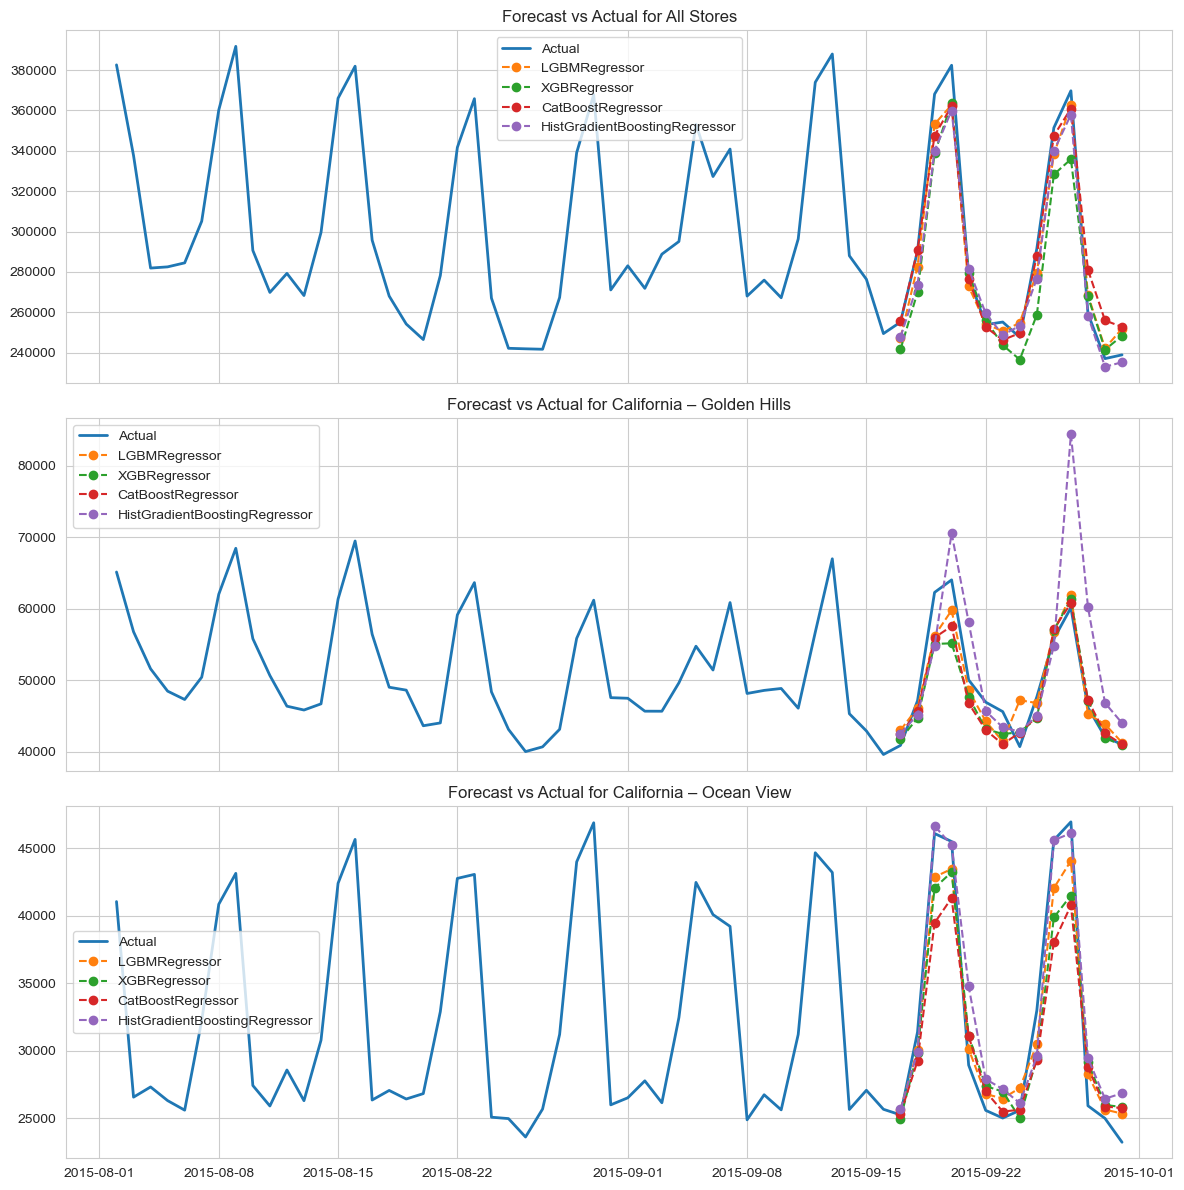

In [9]:
plot_forecasts(df, mlf_forecast, mlf.models)  # customize stores

In [10]:
mlf_rmse = calc_rmse(test_df, mlf_forecast)

LGBMRegressor: 4223.72
XGBRegressor: 6490.44
CatBoostRegressor: 4675.68
HistGradientBoostingRegressor: 5362.29


# Neural Forecast

In [11]:
from neuralforecast.models import NHITS  # or RNN, TCN, NBEATS, etc.
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.models import RNN
from neuralforecast.models import LSTM
from neuralforecast.models import TCN


# Define the model
models = [
    NHITS(input_size=4 * h,  # e.g. 4 times the horizon
          h=h,
          max_steps=1000,
          scaler_type='standard',
          val_check_steps=100),
    # NBEATS(input_size=4*h,
    #        h=h,
    #        max_steps=1000),
    # RNN(input_size=4*h, h=h, max_steps=1000),
    # LSTM(input_size=4*h, h=h, max_steps=1000),
    # TCN(input_size=4*h, h=h, max_steps=1000)
]

# Initialize forecast object
nf = NeuralForecast(models=models, freq='D')

Seed set to 1


In [12]:
# Fit the model

# nf.fit(train_df[train_vars])
# nf_forecast = nf.predict()
# plot_forecasts(df, nf_forecast)
# nf_rmse = calc_rmse(test_df, nf_forecast)

# Hierarchical Forecast

In [13]:
store_ids = df['unique_id'].unique()
store_ids[store_ids != 'All Stores']


array(['Texas – Lone Star Mall', 'Texas – Alamo Heights',
       'California – Redwood Center', 'Wisconsin – Lakeview Plaza',
       'California – Ocean View', 'California – Sunset Plaza',
       'California – Golden Hills', 'Wisconsin – Maple Grove',
       'Texas – Riverwalk Market', 'Wisconsin – Badger Crossing'],
      dtype=object)

# Test

In [31]:
store_id_map = df[['store_id', 'unique_id']].drop_duplicates()

def preprocess_submission(df, calendar, train_df):
    submission_df = df.copy()
    submission_df[['store_id', 'ds']] = submission_df['id'].str.split('_', expand=True)
    submission_df['store_id'] = submission_df['store_id'].astype(int)
    submission_df['ds'] = pd.to_datetime(submission_df['ds'])
    submission_df = submission_df.merge(store_id_map, on='store_id', how='left')
    submission_df = preprocess(submission_df, calendar, max(train_df['timestep']) + 1)

    return submission_df


def predict_recursive(nf: NeuralForecast, history_df: DataFrame, future_df: DataFrame):
    future = future_df.copy()
    history = history_df.copy()
    vars_ext = train_vars + ['timestep']

    h = nf.h
    start = min(future['timestep'])
    end = max(future['timestep'])
    preds = []

    for i in range(start, end, h):
        nf.fit(history[train_vars])
        near_future = preprocess(nf.make_future_dataframe(), calendar, i)
        pred = nf.predict(history, futr_df=near_future)
        pred['y'] = pred[nf._get_model_names()].mean(axis=1)
        preds.append(pred)
        pred = pred.merge(future, how='left', on=['unique_id', 'ds'])[vars_ext]
        history = pd.concat([history, pred], ignore_index=True)[train_vars]

    predictions = pd.concat(preds, ignore_index=True)
    results = future.merge(predictions, how='left', on=['unique_id', 'ds'])
    results = results.drop(columns=['prediction'])

    return results


In [34]:
print(f"\n=== TRAINING ON FULL DATA FOR SUBMISSION ===")

# Train fresh models on full dataset for submission
mlf_submission = MLForecast(
    models=[
        lgb.LGBMRegressor(),
        xgb.XGBRegressor(),
        CatBoostRegressor(verbose=0),
        HistGradientBoostingRegressor()
    ],
    freq='D',
    lags=[1, 7, 14],
    date_features=['dayofweek', 'month', 'is_month_end'],
    num_threads=4
)

# Fit on FULL dataset for submission
mlf_submission.fit(df[train_vars], static_features=[])

nf_submission = NeuralForecast(models=[
    NHITS(input_size=4 * h, h=h, max_steps=1000, scaler_type='standard', val_check_steps=100)
], freq='D')

# nf_submission.fit(df[train_vars])

print("Models trained on full dataset for submission")

weights = {'LGBMRegressor': 0.0,
 'XGBRegressor': 0.0,
 'CatBoostRegressor': 0.0,
 'HistGradientBoostingRegressor': 0,
 'NHITS': 1.0}


print(f"\n=== GENERATING SUBMISSION FORECASTS ===")

submission_df = preprocess_submission(submission, calendar, df)

mlf_submission_forecast = mlf_submission.predict(h=len(submission_df['ds'].unique()), X_df=submission_df[test_vars])
print(f"ML submission forecast shape: {mlf_submission_forecast.shape}")

nf_submission_forecast = predict_recursive(nf_submission, df, submission_df)
print(f"Neural submission forecast shape: {nf_submission_forecast.shape}")


# Merge forecasts
ensemble_submission = mlf_submission_forecast.merge(nf_submission_forecast, how='left', on=['unique_id', 'ds'])

def create_weighted_ensemble_submission(forecast_df, weights):
    """Create weighted ensemble using validation-derived weights"""
    if not weights:
        print("No validation weights available, using equal weights for available models")
        # Find available model columns (exclude metadata columns)
        model_cols = [col for col in forecast_df.columns
                     if col not in ['unique_id', 'ds', 'id', 'store_id', 'timestep']
                     and not col.startswith('event_')]

        if model_cols:
            print(f"Using equal weights for: {model_cols}")
            return forecast_df[model_cols].mean(axis=1)
        else:
            print("No model columns found!")
            return pd.Series(0, index=forecast_df.index)

    weighted_sum = 0
    total_weight = 0
    weights_used = {}

    for model, weight in weights.items():
        if model in forecast_df.columns:
            print(f"Applying weight {weight:.3f} to {model}")
            model_pred = forecast_df[model].fillna(0)
            weighted_sum += weight * model_pred
            total_weight += weight
            weights_used[model] = weight
        else:
            print(f"Warning: {model} not found in submission forecast")

    if total_weight > 0:
        print(f"Total weight used: {total_weight:.3f}")
        print(f"Weights applied: {weights_used}")
        return weighted_sum
    else:
        print("No valid weights applied, using first available model")
        available_cols = [col for col in forecast_df.columns if col not in ['unique_id', 'ds']]
        return forecast_df[available_cols[0]] if available_cols else pd.Series(0, index=forecast_df.index)

# Apply weights to create ensemble
ensemble_submission['y'] = create_weighted_ensemble_submission(ensemble_submission, weights)

# Apply domain knowledge: Set Christmas Day to 0
christmas_mask = (ensemble_submission['ds'].dt.month == 12) & (ensemble_submission['ds'].dt.day == 25)
ensemble_submission.loc[christmas_mask, 'y'] = 0
print(f"Set {christmas_mask.sum()} Christmas predictions to 0")

print(f"\n=== CREATING SUBMISSION FILE ===")

# Prepare submission in required format
submission_result = ensemble_submission.copy()
submission_result['prediction'] = submission_result['y']

# Keep only required columns: id, prediction
final_submission = submission_result[['id', 'prediction']].copy()

# Ensure no negative predictions
final_submission['prediction'] = final_submission['prediction'].clip(lower=0)

print(f"Final submission shape: {final_submission.shape}")
print(f"Prediction statistics:")
print(f"  Mean: {final_submission['prediction'].mean():.2f}")
print(f"  Min: {final_submission['prediction'].min():.2f}")
print(f"  Max: {final_submission['prediction'].max():.2f}")
print(f"  NaN values: {final_submission['prediction'].isna().sum()}")

# Save submission file
final_submission.to_csv('submission.csv', index=False)
print(f"\nSubmission saved to 'submission.csv'")

# Show sample of submission
print(f"\nSample submission:")
print(final_submission.head(10))


=== TRAINING ON FULL DATA FOR SUBMISSION ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 849
[LightGBM] [Info] Number of data points in the train set: 18612, number of used features: 37
[LightGBM] [Info] Start training from score 43222.939866


Seed set to 1


Models trained on full dataset for submission

=== GENERATING SUBMISSION FORECASTS ===


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.085    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


ML submission forecast shape: (1012, 6)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.085    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.085    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.085    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.085    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.085    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.085    Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1000` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Neural submission forecast shape: (1012, 42)
Applying weight 0.000 to LGBMRegressor
Applying weight 0.000 to XGBRegressor
Applying weight 0.000 to CatBoostRegressor
Applying weight 0.000 to HistGradientBoostingRegressor
Applying weight 1.000 to NHITS
Total weight used: 1.000
Weights applied: {'LGBMRegressor': 0.0, 'XGBRegressor': 0.0, 'CatBoostRegressor': 0.0, 'HistGradientBoostingRegressor': 0, 'NHITS': 1.0}
Set 11 Christmas predictions to 0

=== CREATING SUBMISSION FILE ===
Final submission shape: (1012, 2)
Prediction statistics:
  Mean: 54296.05
  Min: 0.00
  Max: 413779.12
  NaN values: 0

Submission saved to 'submission.csv'

Sample submission:
           id     prediction
0  0_20151001  242662.343750
1  0_20151002  310210.343750
2  0_20151003  375181.187500
3  0_20151004  382110.437500
4  0_20151005  306845.156250
5  0_20151006  280579.250000
6  0_20151007  260657.015625
7  0_20151008  260453.656250
8  0_20151009  314667.593750
9  0_20151010  384086.156250


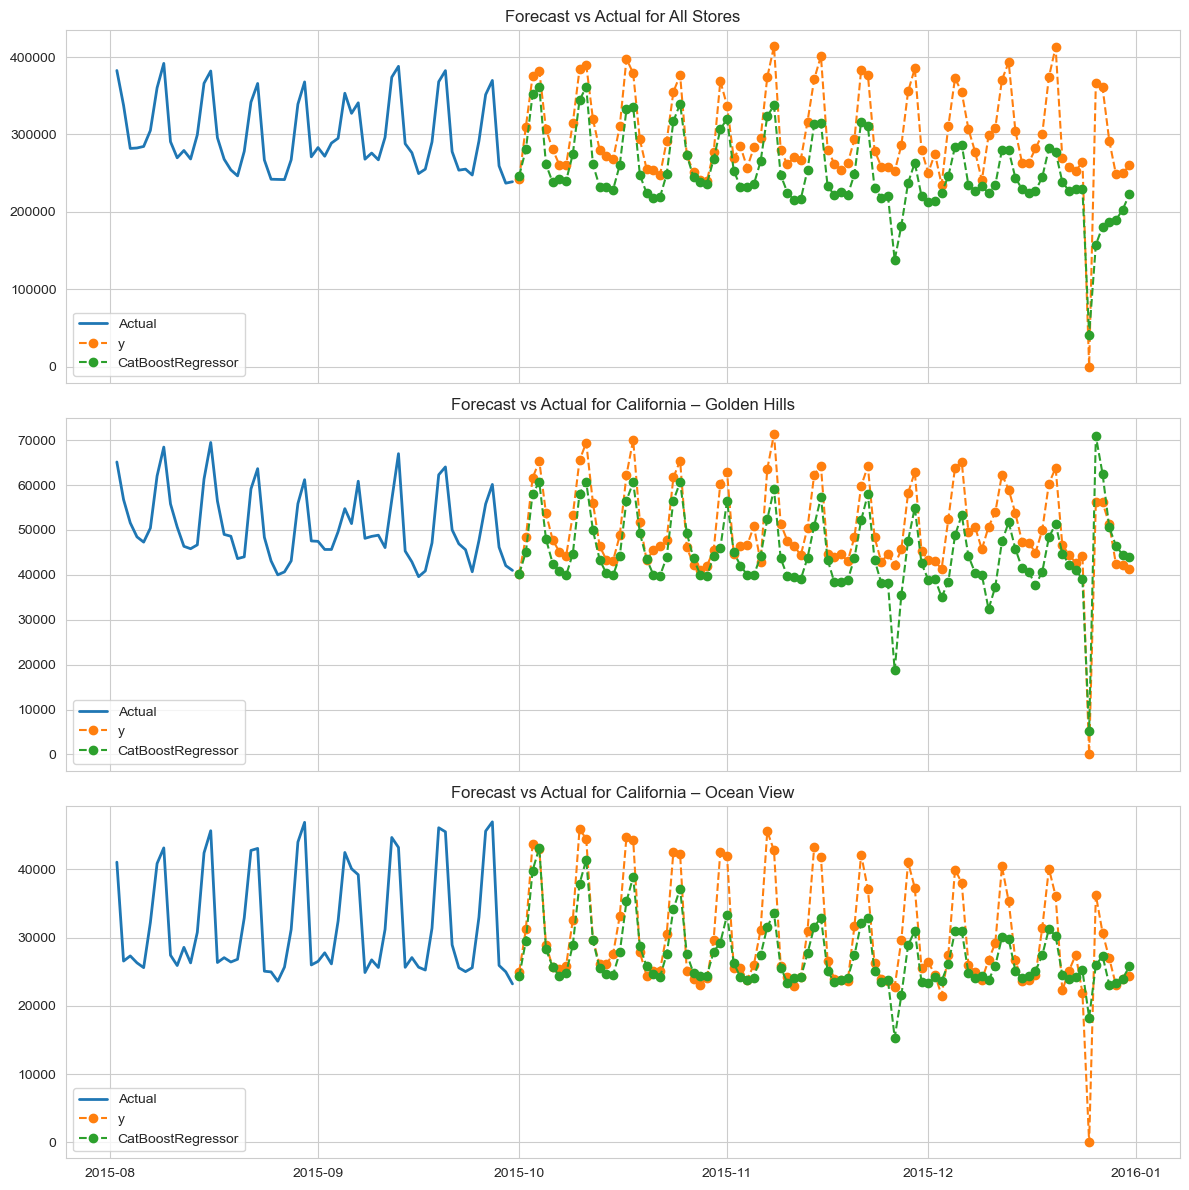

In [37]:
plot_forecasts(df, ensemble_submission, ['y', 'CatBoostRegressor'])